In [ ]:
# import tensorflow as tf

In [ ]:
# tf.enable_eager_execution()

In [ ]:
# import numpy as np
# import tensorflow as tf
# y_pred = np.array([[0.2, 0.7, 0.1], [0., 1., 0.], [0.0, 0.8, 0.2]])
# y_true = np.array([0., 1., 0.])

In [ ]:
# L = K.losses.categorical_crossentropy(tf.constant(y_pred), tf.constant(y_true))
# L.numpy()

In [ ]:
# (
#  K.losses.categorical_crossentropy(tf.constant(y_pred[0]), tf.constant(y_true)),
#  K.losses.categorical_crossentropy(tf.constant(y_pred[1]), tf.constant(y_true)),
#  K.losses.categorical_crossentropy(tf.constant(y_pred[2]), tf.constant(y_true))
# )

In [ ]:
# m1_out = np.array([
#     [0.8, 0.1, 0.1, 0.],
#     [0.1, 0.2, 0.2, 0.5]])
# m2_out = np.array([
#     [1., 0., 0., 0.],
#     [0.1, 0.2, 0.2, 0.5]])
# m3_out = np.array([
#     [0., 0.2, 0.8, 0.],
#     [0., 0., 0., 1.0]
# ])
# y = K.variable(np.array([
#     [1., 0., 0., 0.],
#     [0., 0., 0., 1.]
# ]).reshape((-1, 1, 4)), dtype='float64')
# x = K.stack([m1_out, m2_out, m3_out], axis=1)
# x, y

In [ ]:
# entropy = K.categorical_crossentropy(x, y)
# K.eval(K.categorical_crossentropy(x, y)), K.eval(K.sum(entropy, axis=1))

In [ ]:
# K.categorical_crossentropy(p, K.variable(y_train.reshape((-1, 1, 10))))

- https://arxiv.org/pdf/1811.03575.pdf
- https://arxiv.org/abs/1502.01852  

In [1]:
import keras
import keras.backend as K

def kl_regularization(layers):
    pass

def ensemble_crossentropy(y_true, y_pred):
    entropy = K.categorical_crossentropy(y_true, y_pred)
    return K.sum(entropy, axis=1)

def loss(y_true, y_pred):
    entropy = ensemble_crossentropy(y_true, y_pred)
    return K.sum(entropy)

Using TensorFlow backend.


In [24]:
N_MODELS = 5

main_input = keras.layers.Input(shape=(28, 28, 1))


# need to stack all outputs into a single layer because keras expects
# n_outputs = len(y_train)
class Stack(keras.layers.Layer):
    def call(self, X):
        return K.stack(X, axis=1)
    
    def compute_output_shape(self, input_shape):
        # assumes all input shapes are the same
        return (input_shape[0][0], len(input_shape), input_shape[0][1])


def make_layers(input_):
    # from
    # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(10, activation='softmax')(x)
    return x

layers = [make_layers(main_input) for _ in range(N_MODELS)]
ensemble_output = Stack()(layers)
ensemble = keras.models.Model(inputs=main_input, outputs=ensemble_output)

In [25]:
ensemble.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 26, 26, 32)   320         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 26, 26, 32)   320         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 26, 26, 32)   320         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_37 

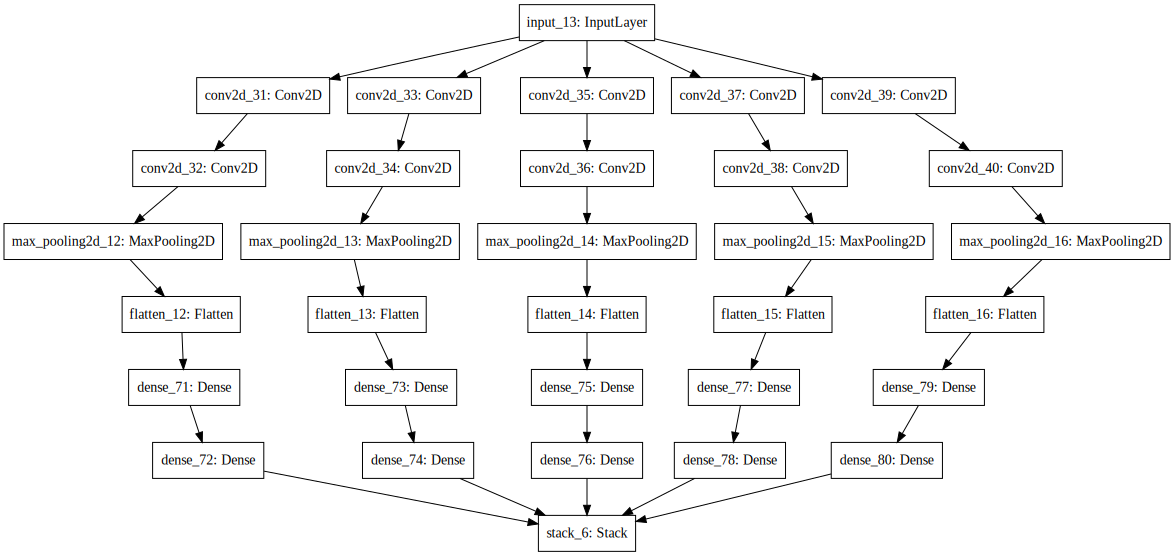

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(ensemble).create(prog='dot', format='svg'))

In [27]:
ensemble.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

In [64]:
from keras.datasets.mnist import load_data
import numpy as np
from unittest import mock

(X_train, y_train), (X_test, y_test) = load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = keras.utils.to_categorical(y_train, 10)
y_train = y_train[:, np.newaxis, :]
y_test = keras.utils.to_categorical(y_test, 10)
y_test = y_test[:, np.newaxis, :]

In [65]:
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 1, 10))

In [66]:
ensemble.fit(
    X_train, y_train,
    batch_size=128,
    validation_data=(X_test, y_test),
    epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 490s 8ms/step - loss: 108.2306 - acc: 0.9489 - val_loss: 35.4825 - val_acc: 0.9821
Epoch 2/10
 1280/60000 [..............................] - ETA: 8:02 - loss: 30.8688 - acc: 0.9831

KeyboardInterrupt: 

In [ ]:
p = ensemble.predict(X_train)
p.shape